# plotting correlation between heterogeneous reconstruction and MD trajectory
This notebook computes the correlation between frames of the MD trajectory and volumes reconstructed by cryoDRGN / cryoSPARC

In [1]:
# imports
import os
import numpy as np
import gemmi
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed
import warnings
import matplotlib.pyplot as plt

from emmer.pdb.convert.convert_pdb_to_map import convert_pdb_to_map
from emmer.ndimage.filter.low_pass_filter import low_pass_filter

In [3]:
# inputs and parameters
n_frames = 50
resolution = 3
n_jobs = 12

## 1-dimensional latent space, plotted in figure S5E

vseries_dir = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J527_series_000"
pdb_dir = "../data/6xm5_steered_Roodmus_1/pdb"
ensemble_filename = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J527_series_000/ensemble_fit_to_vseries.pdb"
mask_filename = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J527_series_000/ensemble_mask.mrc"
figures_dir = "../data/6xm5_steered_Roodmus_2/figures/"
latent_coordinates = np.linspace(-1.0827, 0.5707, 41)
inverted_maps = True

## 2-dimensional latent space, plotted in figure S5F

# vseries_dir = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J620_series_000"
# pdb_dir = "../data/6xm5_steered_Roodmus_1/pdb"
# ensemble_filename = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J620_series_000/ensemble_fit_to_vseries.pdb"
# mask_filename = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J620_series_000/ensemble_mask.mrc"
# figures_dir = "../data/6xm5_steered_Roodmus_2/figures/"
# latent_coordinates = np.linspace(-0.56, 0.69866663, 41)
# inverted_maps = True

# vseries_dir = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J620_series_001"
# pdb_dir = "../data/6xm5_steered_Roodmus_1/pdb"
# ensemble_filename = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J620_series_000/ensemble_fit_to_vseries.pdb"
# mask_filename = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J620_series_000/ensemble_mask.mrc"
# figures_dir = "../data/6xm5_steered_Roodmus_2/figures/"
# latent_coordinates = np.linspace(-0.80533332, 0.87999994, 41)
# inverted_maps = True

# vseries_dir = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J641_series_000"
# pdb_dir = "../data/6xm5_steered_Roodmus_1/pdb"
# ensemble_filename = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J620_series_000/ensemble_fit_to_vseries.pdb"
# mask_filename = "../data/6xm5_steered_Roodmus_2/cryosparc_P51_J620_series_000/ensemble_mask.mrc"
# figures_dir = "../data/6xm5_steered_Roodmus_2/figures/"
# latent_coordinates = np.linspace(0, 40, 41)
# inverted_maps = True

frames = [r for r in os.listdir(pdb_dir) if r.endswith(".pdb")]
frames.sort()
frames = frames[::int(len(frames)/n_frames)]

if inverted_maps:
    volumes = [r for r in os.listdir(vseries_dir) if r.endswith("inverted.mrc")]
else:
    volumes = [r for r in os.listdir(vseries_dir) if r.endswith(".mrc") and not r.endswith("inverted.mrc")]
volumes.sort()

In [38]:
# step 0: create an ensemble.pdb file from the frames
ensemble_gemmi = gemmi.Structure()
for frame in frames:
    frame_gemmi = gemmi.read_structure(os.path.join(pdb_dir, frame))
    ensemble_gemmi.add_model(frame_gemmi[0])

ensemble_gemmi.write_pdb(os.path.join(vseries_dir, "ensemble.pdb"))



Next, load in the ensemble into ChimeraX and align it to the first volume in the series using fit in volume and manual placement.
Also create a mask from the atomic model using the molmap command. In the case of this protein, the mask will be limited to the moving residues.


In [4]:
# step 1: load each frame and compute the modelmap
vseries_vol0 = gemmi.read_ccp4_map(os.path.join(vseries_dir, volumes[0]))
unitcell = vseries_vol0.grid.unit_cell
size = vseries_vol0.grid.shape
vsize = vseries_vol0.grid.spacing[0]

# create list of frames
frames_fit = []
ensemble_fit_gemmi = gemmi.read_structure(ensemble_filename)
for mdl in ensemble_fit_gemmi:
    tmp_struc = gemmi.Structure()
    tmp_struc.add_model(mdl)
    frames_fit.append(tmp_struc)

modelmaps = []
for frame_gemmi in tqdm(frames_fit):
    map_from_model_unfiltered = convert_pdb_to_map(
        input_pdb=frame_gemmi,
        unitcell=unitcell,
        size=size,
        return_grid=False,
    )
    map_from_model_zyx = low_pass_filter(
        map_from_model_unfiltered, resolution, vsize
    )
    map_from_model = np.rot90(
        np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
    )
    modelmaps.append(map_from_model)


100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


In [5]:
# step 2: correlate each modelmap with the vseries'
def compute_correlation(modelmap, targetmap, mask, i, j):
    """Compute the correlation between two maps"""
    
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
    # apply mask to both maps
    modelmap_masked = modelmap * mask
    targetmap_masked = targetmap * mask
    # compute the mean of the two maps
    mean_modelmap = np.mean(modelmap_masked)
    mean_targetmap = np.mean(targetmap_masked)
    # compute the standard deviation of the two maps
    std_modelmap = np.std(modelmap_masked)
    std_targetmap = np.std(targetmap_masked)
    # compute the correlation
    correlation = np.mean((modelmap_masked - mean_modelmap) * (targetmap_masked - mean_targetmap)) / (std_modelmap * std_targetmap)
    return correlation, i, j


# load vseries
vseries_stack = []
for volume in volumes:
    vseries_vol = gemmi.read_ccp4_map(os.path.join(vseries_dir, volume))
    vseries_stack.append(np.array(vseries_vol.grid))


indecies = itertools.product(range(n_frames), range(len(volumes)))
mask = gemmi.read_ccp4_map(mask_filename)
mask_data = np.array(mask.grid, copy=False)
# threshold = mask_data[mask_data > 0].mean() - 2 * mask_data[mask_data > 0].std()
threshold = 0.5
mask_data[mask_data < threshold] = 0
mask_data[mask_data >= threshold] = 1
# mask_data = np.rot90(np.flip(mask_data, axis=0), axes=(2, 0))

correlations = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(compute_correlation)(modelmaps[i], vseries_stack[j], mask_data, i, j)
    for i, j in indecies
)
correlation_matrix = np.zeros((n_frames, len(volumes)))
for correlation, i, j in correlations:
    correlation_matrix[i, j] = correlation

print(f"correlation average: {np.mean(correlation_matrix)}")
print(f"correlation std: {np.std(correlation_matrix)}")
print(f"correlation min: {np.min(correlation_matrix)}")
print(f"correlation max: {np.max(correlation_matrix)}")


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    6.5s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.7s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    6.9s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    7.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    7.2s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    7.3s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1992s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    7.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    7.5s
[Parallel(n_jobs=12)]: Done 122 tasks      | elapsed:    7.7s
[Parallel(n_jobs=12)]: Done 156 tasks      | elapsed:    8.0s
[Parallel(n_jobs=12)]: Done 194 tasks      | elapsed:    8.3s
[Parallel(n_jobs=12)]: Done 232 ta

correlation average: 0.45082173752186905
correlation std: 0.11617664042948961
correlation min: 0.2416038278133017
correlation max: 0.6391473465229378


threshold: 0.5


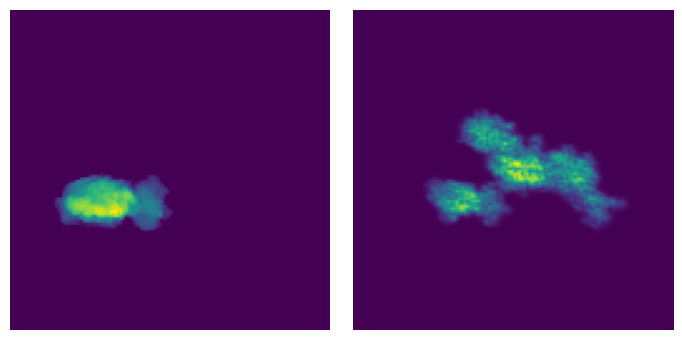

In [6]:
# create projections of the mask
print(f"threshold: {threshold}")
fig, ax = plt.subplots(1,2, figsize=(7, 3.5))
ax[0].imshow(mask_data.sum(axis=0))
ax[1].imshow(vseries_stack[0].sum(axis=0))
ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()


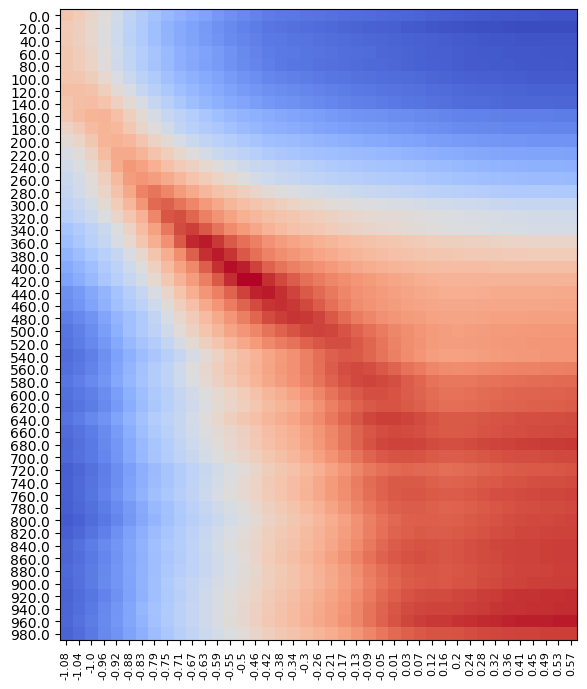

In [9]:
# step 3: plot the correlation matrix
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(correlation_matrix, cmap="coolwarm")
# change the xtick labels for latents
ax.set_xticks(np.arange(len(volumes)))
ax.set_xticklabels(
    [np.round(r, 2) for r in latent_coordinates], rotation=90, fontsize=8)
# set the y-ticklabels to the frames in the pdb_dir
conformation_names = [float(r.split("_")[1].strip(".pdb")) for r in frames]
ax.set_yticks(np.arange(len(frames)))
# ax.set_yticklabels(conformation_names)
ax.set_yticklabels([np.round(r*0.1, 1) for r in conformation_names])
fig.tight_layout()

fig.savefig(os.path.join(figures_dir, f"{os.path.basename(vseries_dir)}_correlation_matrix.png"), dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(figures_dir, f"{os.path.basename(vseries_dir)}_correlation_matrix.pdf"), bbox_inches="tight")
